In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install imblearn
% matplotlib inline
import warnings
warnings.filterwarnings(action='once')

In [0]:
import pandas as pd
import collections
from sklearn import preprocessing, metrics, model_selection
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import sklearn.metrics as metrics
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE 
from sklearn import svm


## TO-DO LIST
* test thresholding cutoff point
* improve accuracy

In [0]:
train_data = pd.read_csv('result.csv')\
              .drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],axis=1)
train_data.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.00,Supplies,My students need matching shirts to wear for d...
1,p063374,403c6783e9286e51ab318fba40f8d729,Mrs.,DE,2016-11-05 10:01:51,Grades PreK-2,"Applied Learning, Literacy & Language","Character Education, Literature & Writing",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,NaN,NaN,My students need tablets in order to communic...,0,1,{Amazon - Fire Kids Edition - 7'- Tablet - 16G...,727.36,Technology,My students need tablets in order to communic...
2,p114989,b580c11b1497a0a67317763b7f03eb27,Ms.,IN,2016-09-13 22:35:57,Grades 6-8,Math & Science,Mathematics,Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,NaN,NaN,My students need seating that allows the most ...,13,1,"{Kore Patented WOBBLE Chair, Made in the USA, ...",319.80,Supplies,My students need seating that allows the most ...


## Feature Selection

In [0]:
train_data.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'description', 'total_cost', 'Project Resource Category',
       'Project Need Statement'],
      dtype='object')

In [0]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.split(", ").to_frame()
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.split(", ").to_frame()
train_data['Project Resource Category'] = train_data['Project Resource Category'].str.split(", ").to_frame()

train_data.head(1)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"[Music & The Arts, Health & Sports]","[Performing Arts, Team Sports]",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.0,[Supplies],My students need matching shirts to wear for d...


In [0]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].apply(collections.Counter)
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].apply(collections.Counter)
train_data['Project Resource Category'] = train_data['Project Resource Category'].apply(collections.Counter)

project_subject_categories = pd.DataFrame.from_records(train_data['project_subject_categories']).fillna(value=0).add_prefix("proj_cat_")
project_subject_subcategories = pd.DataFrame.from_records(train_data['project_subject_subcategories']).fillna(value=0).add_prefix("proj_sub_cat_")
Project_Resource_Category = pd.DataFrame.from_records(train_data['Project Resource Category']).fillna(value=0).add_prefix("res_cat_")

train_data = pd.concat([train_data, project_subject_categories], axis=1)
train_data = pd.concat([train_data, project_subject_subcategories], axis=1)
train_data = pd.concat([train_data, Project_Resource_Category], axis=1)

train_data.head(1)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,...,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"{'Music & The Arts': 1, 'Health & Sports': 1}","{'Performing Arts': 1, 'Team Sports': 1}",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_data.plot

In [0]:
assert(len(train_data.columns))==len(set(train_data.columns))
!pip install iteration_utilities
from iteration_utilities import duplicates

You are using pip version 18.0, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
train_data = train_data.loc[:,~train_data.columns.duplicated()]
train_data = train_data.drop(columns = ['proj_sub_cat_Care & Hunger', 'proj_sub_cat_Special Needs', 'proj_sub_cat_Warmth'])
len(train_data.columns)

74

In [0]:
train_df = train_data.select_dtypes(exclude=['object','category'])
print(len(train_df.columns))
print(train_df.dtypes.unique())
cat_columns = [col for col in train_df.columns if 'cat' in col]
train_df.head(1)

57
[dtype('int64') dtype('float64')]


,teacher_number_of_previously_posted_projects,project_is_approved,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,...,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,1,0,400.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_df[cat_columns] = train_df[cat_columns].astype('int8')
train_df.head(3)

/Users/estelwang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,teacher_number_of_previously_posted_projects,project_is_approved,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,...,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,1,0,400.00,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,727.36,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,1,319.80,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
train_df.columns

Index(['teacher_number_of_previously_posted_projects', 'project_is_approved',
       'total_cost', 'proj_cat_Music & The Arts', 'proj_cat_Health & Sports',
       'proj_cat_Applied Learning', 'proj_cat_Literacy & Language',
       'proj_cat_Math & Science', 'proj_cat_Special Needs',
       'proj_cat_History & Civics', 'proj_cat_Warmth',
       'proj_cat_Care & Hunger', 'proj_sub_cat_Performing Arts',
       'proj_sub_cat_Team Sports', 'proj_sub_cat_Character Education',
       'proj_sub_cat_Literature & Writing', 'proj_sub_cat_Mathematics',
       'proj_sub_cat_Literacy', 'proj_sub_cat_Early Development',
       'proj_sub_cat_Environmental Science', 'proj_sub_cat_Health & Wellness',
       'proj_sub_cat_Music', 'proj_sub_cat_Applied Sciences',
       'proj_sub_cat_Visual Arts', 'proj_sub_cat_ESL',
       'proj_sub_cat_Extracurricular', 'proj_sub_cat_Gym & Fitness',
       'proj_sub_cat_History & Geography',
       'proj_sub_cat_College & Career Prep',
       'proj_sub_cat_Health & Life

In [0]:
X = train_df.loc[:, train_df.columns != 'project_is_approved']
y = train_df.loc[:, train_df.columns == 'project_is_approved']
print(X.shape)
print(y.shape)

print(type(y))
print("Number of features: {}".format(len(X.columns)))

(121308, 56)
(121308, 1)
<class 'pandas.core.frame.DataFrame'>
Number of features: 56


### Normalize numerical features

In [0]:
# standardize numeric features: teacher_number_of_previously_posted_projects, total_cost
scaler = MinMaxScaler()
stand_cols = ['teacher_number_of_previously_posted_projects', 'total_cost']
for col_name in stand_cols:
    X[col_name] = scaler.fit_transform(X[col_name].values.reshape(-1,1))

/Users/estelwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/estelwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Create train, test, and validation sets

In [0]:
# split X, Y to train, valid and test by 6:2:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print("Train: {},  Test: {}".format(X_train.shape, X_test.shape))

Train: (97046, 56),  Test: (24262, 56)


In [0]:
train_breakdown = y_train['project_is_approved'].value_counts()
test_breakdown = y_test['project_is_approved'].value_counts()
print("Training Set")
print(train_breakdown)
print("")
print("Test Set")
print(test_breakdown)

Training Set
1    88278
0     8768
Name: project_is_approved, dtype: int64

Test Set
1    22080
0     2182
Name: project_is_approved, dtype: int64


# SMOTE for training

In [0]:
# use SMOTE with only the train set
os = SMOTE(random_state=40)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['project_is_approved'])

# we can check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not approved in oversampled data",len(os_data_y[os_data_y['project_is_approved']==0]))
print("Number of approved in oversampled data",len(os_data_y[os_data_y['project_is_approved']==1]))
print("Proportion of not approved data in oversampled data is ",len(os_data_y[os_data_y['project_is_approved']==0])/len(os_data_X))
print("Proportion of approved data in oversampled data is ",len(os_data_y[os_data_y['project_is_approved']==1])/len(os_data_X))
print(os_data_X.shape)

/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  176556
Number of not approved in oversampled data 88278
Number of approved in oversampled data 88278
Proportion of not approved data in oversampled data is  0.5
Proportion of approved data in oversampled data is  0.5
(176556, 56)


## Building model

In [0]:
X_train[X_train.columns[~X_train.columns.isin(stand_cols)]] = X_train[X_train.columns[~X_train.columns.isin(stand_cols)]].astype('int')
X_train.shape

/Users/estelwang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(97046, 56)

### Model Fit 1

**train with all smote data**

In [0]:
logreg = LogisticRegressionCV(random_state=40, max_iter=1000, solver='lbfgs',multi_class='multinomial', cv=5)
lr_clf = logreg.fit(os_data_X, os_data_y)


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of lr_clf on train set: 0.60
Accuracy of lr_clf on test set: 0.60


In [0]:
print('Accuracy of lr_clf on train set: {:.5f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of lr_clf on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of lr_clf on train set: 0.60463
Accuracy of lr_clf on test set: 0.60222


In [0]:
# model_lr = LogisticRegression(random_state=40, max_iter=1000, solver='lbfgs',multi_class='multinomial')
# results_kfold = model_selection.cross_val_score(model_lr, os_data_X, os_data_y, cv=5)

**Run classifier with cross-validation and plot ROC curves**

/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1070   684]
 [ 6956 10700]]
accuracy 0.6063884595569294


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1056   698]
 [ 6975 10681]]
accuracy 0.604688304997424


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1092   662]
 [ 7066 10590]]
accuracy 0.601854714064915


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1121   632]
 [ 7021 10634]]
accuracy 0.6056780708985985


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1064   689]
 [ 7074 10581]]
accuracy 0.6000103050288541


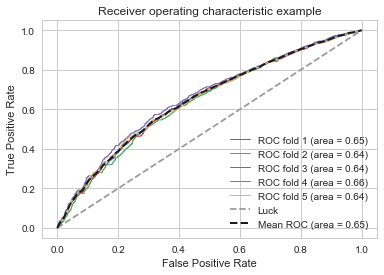

In [0]:
import numpy as np
from scipy import interp
skf = StratifiedKFold(n_splits=5,random_state=40)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
matrix = []
i=1
acc_scores_lr1 = []

os = SMOTE(random_state=40)
columns = X_train.columns


for train, test in skf.split(X_train, y_train):
    
    train_data_x = X_train.iloc[train]
    train_data_y = y_train.iloc[train]
    val_data_X = X_train.iloc[test]
    val_data_y = y_train.iloc[test]
    
    os_data_X, os_data_y=os.fit_sample(train_data_x, train_data_y)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['project_is_approved'])
    
    clf =  model_lr.fit(os_data_X, os_data_y)
    probas_ = clf.predict_proba(val_data_X)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(val_data_y, probas_[:, 1])
    print("confusion matrix", metrics.confusion_matrix(val_data_y, clf.predict(val_data_X)) )
    print("accuracy", metrics.accuracy_score(val_data_y, clf.predict(val_data_X)) )
    matrix.append( metrics.confusion_matrix(val_data_y, clf.predict(val_data_X)))
    acc_scores_lr1.append(metrics.accuracy_score(val_data_y, clf.predict(val_data_X)))
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i=i+1

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
print(sum(matrix))
print(sum(acc_scores_lr1)/ len(acc_scores_lr1) )
print(acc_scores_lr1)
np.std(np.array(acc_scores_lr1))

[[ 5403  3365]
 [35092 53186]]
0.6037239709093442
[0.6063884595569294, 0.604688304997424, 0.601854714064915, 0.6056780708985985, 0.6000103050288541]


0.0024138509555027892

## testing lr_clf1

testing accuracy:  0.6022174594015333
confusion maxtrix [[ 1367   815]
 [ 8836 13244]]
AUC ROC 0.6131541498957214
roc auc 0.6131541498957214


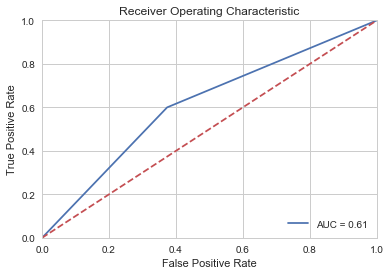

In [0]:
lr_y_pred = lr_clf.predict(X_test)
print("testing accuracy: ",metrics.accuracy_score(y_test, lr_y_pred) )
print("confusion maxtrix",metrics.confusion_matrix(y_test, lr_y_pred))
print("AUC ROC", metrics.roc_auc_score(y_test, lr_y_pred))
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("roc auc",roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature Reduction: First Attempt

In [0]:
est = sm.Logit(os_data_y, os_data_X)
est2 = est.fit()
print(est2.summary())

         Current function value: 0.657345
         Iterations: 35
                            Logit Regression Results                           
Dep. Variable:     project_is_approved   No. Observations:               141246
Model:                           Logit   Df Residuals:                   141193
Method:                            MLE   Df Model:                           52
Date:                 Fri, 15 Nov 2019   Pseudo R-squ.:                 0.05165
Time:                         06:58:04   Log-Likelihood:                -92847.
converged:                       False   LL-Null:                       -97904.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
teacher_number_of_previously_posted_projects     6.1860      0.223  

/Users/estelwang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
p_value_list = [est2.pvalues[i] for i in range(56)]
significant_level = 0.05
p_value_bool = [p_value_list[i] < significant_level for i in range(56)]
num_true = sum(p_value_bool)
print("The number of significant features: {}".format(num_true))

The number of significant features: 31


In [0]:
### Model Fit 2

In [0]:
assert(len(p_value_bool)==os_data_X.shape[1])
model2_col = os_data_X.columns[p_value_bool]
print(model2_col)
print(len(model2_col))
os_data_X2 = os_data_X[model2_col]

Index(['teacher_number_of_previously_posted_projects', 'total_cost',
       'proj_cat_Music & The Arts', 'proj_cat_Applied Learning',
       'proj_cat_Literacy & Language', 'proj_cat_Math & Science',
       'proj_cat_Special Needs', 'proj_sub_cat_Literature & Writing',
       'proj_sub_cat_Mathematics', 'proj_sub_cat_Literacy',
       'proj_sub_cat_Early Development', 'proj_sub_cat_Environmental Science',
       'proj_sub_cat_Health & Wellness', 'proj_sub_cat_Applied Sciences',
       'proj_sub_cat_Visual Arts', 'proj_sub_cat_ESL',
       'proj_sub_cat_College & Career Prep',
       'proj_sub_cat_Health & Life Science', 'proj_sub_cat_Other',
       'proj_sub_cat_Social Sciences', 'proj_sub_cat_Parent Involvement',
       'proj_sub_cat_Nutrition Education', 'proj_sub_cat_Civics & Government',
       'proj_sub_cat_Economics', 'res_cat_Supplies', 'res_cat_Technology',
       'res_cat_Books', 'res_cat_Other', 'res_cat_Computers & Tablets',
       'res_cat_Instructional Technology', 'res_ca

In [0]:
logreg2 = LogisticRegressionCV(random_state=40, max_iter=1000, solver='lbfgs',multi_class='multinomial', cv=5)
lr_clf2 = logreg2.fit(os_data_X2, os_data_y)
# X_train2 = X_train[model2_col]
X_test_2 = X_test[model2_col]

/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
print('Accuracy of logistic regression classifier on train set: {:.5f}'.format(logreg2.score(os_data_X2, os_data_y)))
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg2.score(X_test_2, y_test)))

Accuracy of logistic regression classifier on train set: 0.61003
Accuracy of logistic regression classifier on test set: 0.59760


**testing lr_clf2**

testing accuracy:  0.597601187041464
confusion maxtrix [[ 1368   814]
 [ 8949 13131]]
AUC ROC 0.6108244206551627
roc auc 0.6108244206551627


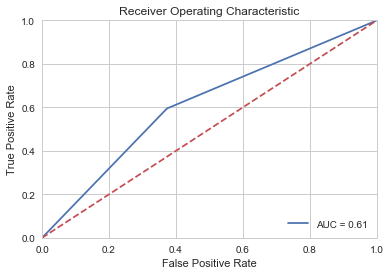

In [0]:
lr_y_pred2 = lr_clf2.predict(X_test_2)
print("testing accuracy: ",metrics.accuracy_score(y_test, lr_y_pred2) )
print("confusion maxtrix",metrics.confusion_matrix(y_test, lr_y_pred2))
print("AUC ROC", metrics.roc_auc_score(y_test, lr_y_pred2))
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_y_pred2)
roc_auc = metrics.auc(fpr, tpr)
print("roc auc",roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**validation performance with lr_clf2**

/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1114   640]
 [ 7060 10596]]
accuracy 0.6032972694487377


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1068   686]
 [ 7071 10585]]
accuracy 0.6003606388459557


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1099   655]
 [ 7203 10453]]
accuracy 0.5951571354971664


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1124   629]
 [ 7159 10496]]
accuracy 0.598722176422094


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1098   655]
 [ 7183 10472]]
accuracy 0.5961459192085737


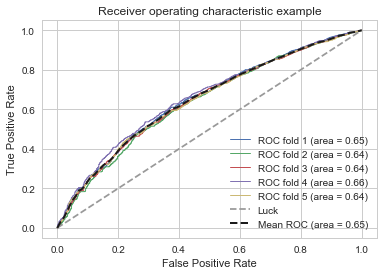

In [0]:
import numpy as np
from scipy import interp
skf = StratifiedKFold(n_splits=5,random_state=40)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
matrix = []
i=1
acc_scores_lr1 = []

os = SMOTE(random_state=40)
columns = X_test_2.columns # use RFE features


for train, test in skf.split(X_train, y_train):
    
    train_data_x = X_train[columns].iloc[train]
    train_data_y = y_train.iloc[train]
    val_data_X = X_train[columns].iloc[test]
    val_data_y = y_train.iloc[test]
    
    os_data_X, os_data_y=os.fit_sample(train_data_x, train_data_y)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['project_is_approved'])
    
    clf =  model_lr.fit(os_data_X, os_data_y)
    probas_ = clf.predict_proba(val_data_X)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(val_data_y, probas_[:, 1])
    print("confusion matrix", metrics.confusion_matrix(val_data_y, clf.predict(val_data_X)) )
    print("accuracy", metrics.accuracy_score(val_data_y, clf.predict(val_data_X)) )
    matrix.append( metrics.confusion_matrix(val_data_y, clf.predict(val_data_X)))
    acc_scores_lr1.append(metrics.accuracy_score(val_data_y, clf.predict(val_data_X)))
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i=i+1

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
print(sum(matrix))
print(sum(acc_scores_lr1)/ len(acc_scores_lr1) )
print(acc_scores_lr1)
np.std(np.array(acc_scores_lr1))

[[ 5503  3265]
 [35676 52602]]
0.5987366278845054
[0.6032972694487377, 0.6003606388459557, 0.5951571354971664, 0.598722176422094, 0.5961459192085737]


0.00293126624923924

In [0]:
# Print Statistics Again With Reduced Features

In [0]:
est_model2 = sm.Logit(os_data_y, os_data_X2)
est2_model2 = est_model2.fit()
print(est2_model2.summary())

Optimization terminated successfully.
         Current function value: 0.658054
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     project_is_approved   No. Observations:               141246
Model:                           Logit   Df Residuals:                   141215
Method:                            MLE   Df Model:                           30
Date:                 Fri, 15 Nov 2019   Pseudo R-squ.:                 0.05063
Time:                         07:24:56   Log-Likelihood:                -92947.
converged:                        True   LL-Null:                       -97904.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
teacher_number_of_previously_pos

# mutinomialNB beta 1

/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[  983   771]
 [ 6824 10832]]
accuracy 0.6087068521380732


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[  977   777]
 [ 6914 10742]]
accuracy 0.6037609479649665


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[  985   769]
 [ 7014 10642]]
accuracy 0.599021123132406


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1000   753]
 [ 6752 10903]]
accuracy 0.6133037922506183


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix [[ 1000   753]
 [ 7312 10343]]
accuracy 0.5844497114591921


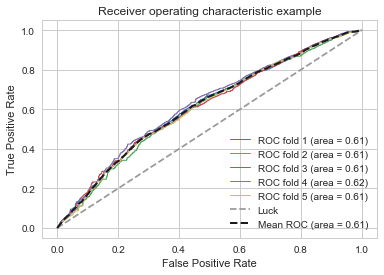

In [0]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from scipy import interp
skf = StratifiedKFold(n_splits=5,random_state=40)
NB = MultinomialNB()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
matrix = []
i=1
acc_scores2 = []

os = SMOTE(random_state=40)
columns = X_train.columns


for train, test in skf.split(X_train, y_train):
    
    train_data_x = X_train.iloc[train]
    train_data_y = y_train.iloc[train]
    val_data_X = X_train.iloc[test]
    val_data_y = y_train.iloc[test]
    
    os_data_X, os_data_y=os.fit_sample(train_data_x, train_data_y)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['project_is_approved'])
    
    clf =  NB.fit(os_data_X, os_data_y)
    probas_ = clf.predict_proba(val_data_X)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(val_data_y, probas_[:, 1])
    print("confusion matrix", metrics.confusion_matrix(val_data_y, clf.predict(val_data_X)) )
    print("accuracy", metrics.accuracy_score(val_data_y, clf.predict(val_data_X)) )
    matrix.append( metrics.confusion_matrix(val_data_y, clf.predict(val_data_X)))
    acc_scores2.append(metrics.accuracy_score(val_data_y, clf.predict(val_data_X)))
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i=i+1

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
print(sum(matrix))
print(acc_scores2)
print(sum(acc_scores2)/len(acc_scores2))

[[ 4945  3823]
 [34816 53462]]
[0.6087068521380732, 0.6037609479649665, 0.599021123132406, 0.6133037922506183, 0.5844497114591921]
0.6018484853890512


In [0]:
NB = MultinomialNB()
nb_clf =  NB.fit(os_data_X, os_data_y)
nb_y_pred = nb_clf.predict(X_test)
print("training accuracy: ", nb_clf.score(os_data_X, os_data_y))
print("testing accuracy: ", metrics.accuracy_score(y_test, nb_y_pred) )
print("testing confusion matrix: ", metrics.confusion_matrix(y_test, nb_y_pred) )

training accuracy:  0.5850006371861858
testing accuracy:  0.5910065122413651
testing confusion matrix:  [[ 1282   900]
 [ 9023 13057]]


/Users/estelwang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing accuracy:  0.5910065122413651
confusion maxtrix [[ 1282   900]
 [ 9023 13057]]
AUC ROC 0.5894420049084075
roc auc 0.5894420049084075


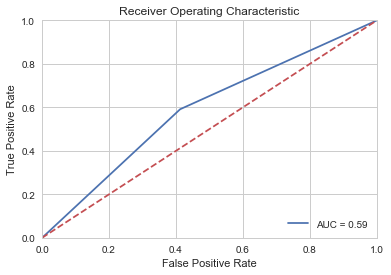

In [0]:
nb_y_pred = nb_clf.predict(X_test)
print("testing accuracy: ",metrics.accuracy_score(y_test, nb_y_pred) )
print("confusion maxtrix",metrics.confusion_matrix(y_test, nb_y_pred))
print("AUC ROC", metrics.roc_auc_score(y_test, nb_y_pred))
fpr, tpr, threshold = metrics.roc_curve(y_test, nb_y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("roc auc",roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SVM CLASSIFIER

In [0]:
classifier = svm.SVC(kernel='linear')
classifier.fit(os_data_X, os_data_y)

In [0]:
y_pred = classifier.predict(X_test)
y_SVM_pred

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test, y_SVM_pred)
confusion_matrix

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_SVM_pred)
roc_auc = metrics.auc(fpr, tpr)
print("roc auc",roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()